In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfda
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda.misc.kernels import uniform, epanechnikov, normal
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
%config InlineBackend.figure_format='retina'
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

In [2]:
from sklearn.decomposition import PCA

In [4]:
df_dcurv_in_19 = pd.read_parquet('../notebook_meeting/generated_data/iNat_curves_19_final.parquet')
df_dcurv_in_22 = pd.read_parquet('../notebook_meeting/generated_data/iNat_curves_22_final.parquet')
df_dcurv_eb_19 = pd.read_parquet('../notebook_meeting/generated_data/eBird_curves_19_final.parquet')
df_dcurv_eb_22 = pd.read_parquet('../notebook_meeting/generated_data/eBird_curves_22_final.parquet')

In [8]:
df_bird_features = pd.read_excel('../data/ELEData/TraitData/AVONET2_eBird.xlsx', sheet_name='AVONET2_eBird')

In [162]:
df_bird_features['AVIBASEID'] = df_bird_features['Avibase.ID2'].apply(
    lambda x: x[8:]
)

In [23]:
birds_curves = set(df_dcurv_eb_19.index)
birds_features = set(df_bird_features['AVIBASE'].values)
common_birds = list(birds_curves.intersection(birds_features))

In [24]:
len(common_birds)

250

In [26]:
df_dcurv_in_19 = df_dcurv_in_19.loc[common_birds, :].copy()
df_dcurv_eb_22 = df_dcurv_eb_22.loc[common_birds, :].copy()
df_dcurv_in_19 = df_dcurv_in_19.loc[common_birds, :].copy()
df_dcurv_in_22 = df_dcurv_in_22.loc[common_birds, :].copy()

In [21]:
fd_dcurv_eb_19 = skfda.FDataGrid(data_matrix=df_dcurv_eb_19.values, grid_points=list(range(0,52)))
fd_dcurv_eb_22 = skfda.FDataGrid(data_matrix=df_dcurv_eb_22.values, grid_points=list(range(0,52)))
fd_dcurv_in_19 = skfda.FDataGrid(data_matrix=df_dcurv_in_19.values, grid_points=list(range(0,52)))
fd_dcurv_in_22 = skfda.FDataGrid(data_matrix=df_dcurv_in_22.values, grid_points=list(range(0,52)))

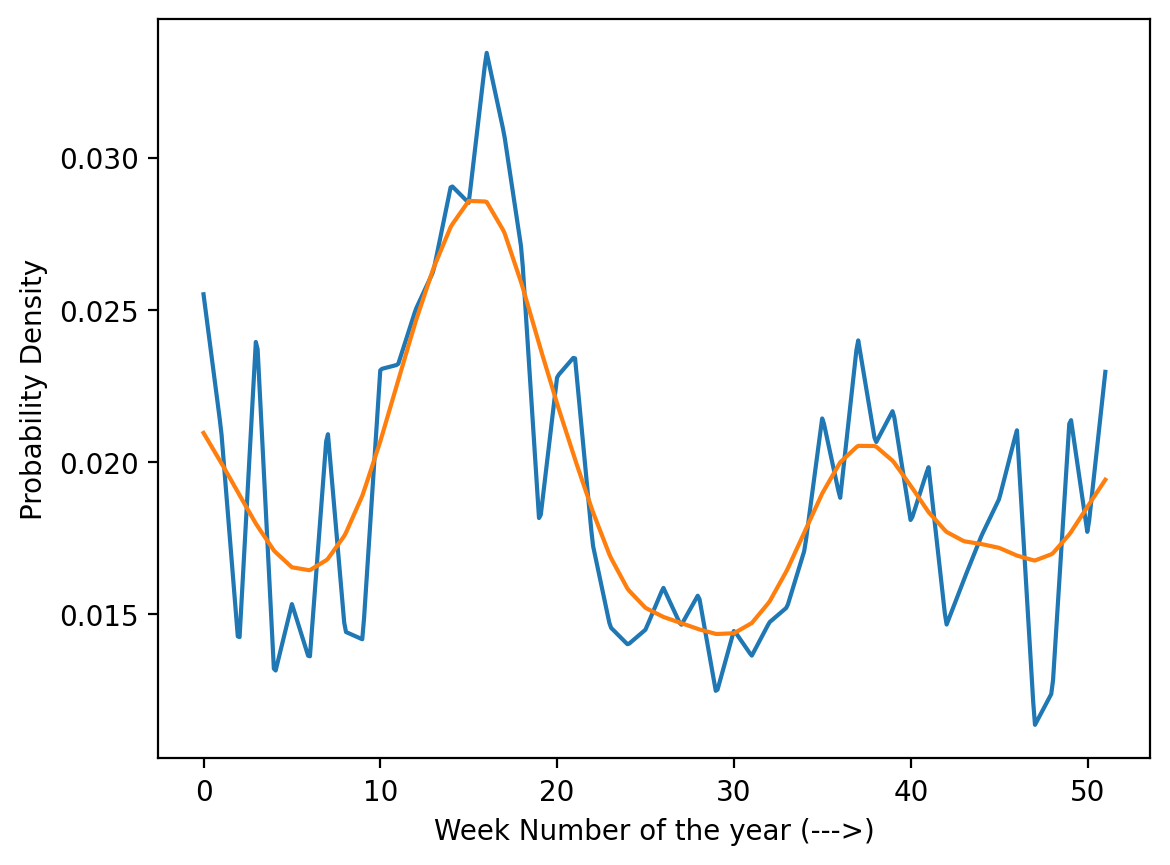

In [190]:
fd_demo = KernelSmoother(
    kernel_estimator=NadarayaWatsonHatMatrix(bandwidth=2, kernel=normal),
).fit_transform(fd_dcurv_eb_19)

fig = fd_dcurv_eb_19[0].plot()
fd_demo[0].plot(fig=fig)
plt.xlabel("Week Number of the year (--->)")
plt.ylabel("Probability Density")
plt.show()

In [50]:
# This code is inspired by the implementation/examples in scikit-fda

knn_neighbors = list(range(1, 10))
bandwidth = np.linspace(
    2,
    20,
    100,
)

# K-nearest neighbours kernel smoothing.

knn = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=KNeighborsHatMatrix()),
    knn_neighbors,
    param_name='kernel_estimator__n_neighbors',
)
knn.fit(fd_dcurv_eb_19)
knn_fd_dcurv_eb_19 = knn.transform(fd_dcurv_eb_19)

# Local linear regression kernel smoothing.
llr = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=LocalLinearRegressionHatMatrix()),
    bandwidth,
    param_name='kernel_estimator__bandwidth',
)
llr.fit(fd_dcurv_eb_19)
llr_fd_dcurv_eb_19 = llr.transform(fd_dcurv_eb_19)

# Nadaraya-Watson kernel smoothing.
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix(kernel=epanechnikov)),
    bandwidth,
    param_name='kernel_estimator__bandwidth',
)
nw.fit(fd_dcurv_eb_19)
nw_fd_dcurv_eb_19 = nw.transform(fd_dcurv_eb_19)

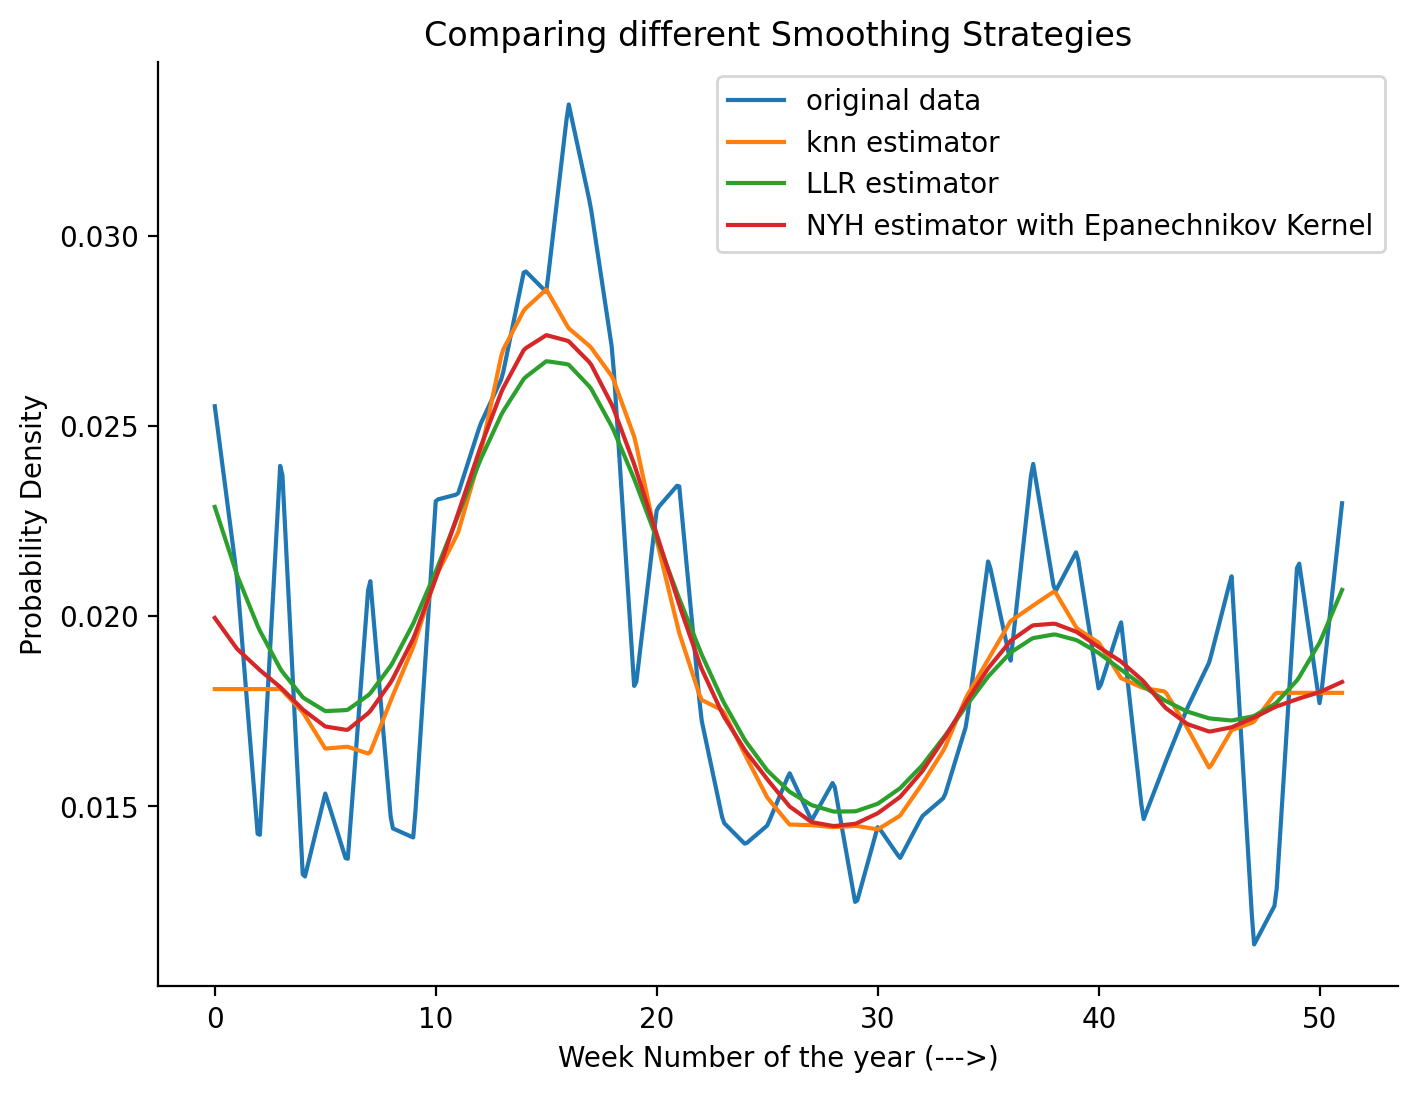

In [191]:
ind = 0
fig, ax = plt.subplots(figsize=(8,6))
fd_dcurv_eb_19[ind].plot(fig=fig,label='original data')
knn_fd_dcurv_eb_19[ind].plot(fig=fig, label='knn estimator')
llr_fd_dcurv_eb_19[ind].plot(fig=fig, label='LLR estimator')
nw_fd_dcurv_eb_19[ind].plot(fig=fig, label='NYH estimator with Epanechnikov Kernel')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Week Number of the year (--->)")
plt.ylabel("Probability Density")
plt.legend()
plt.title("Comparing different Smoothing Strategies")
plt.show()

In [94]:
llr_np_dcurv_eb_19 = llr_fd_dcurv_eb_19.data_matrix.reshape(260,52)

In [95]:
pca_eb_19 = PCA()

In [96]:
pca_eb_19.fit(llr_np_dcurv_eb_19)

PCA()

In [97]:
scree_eb_19 = np.cumsum(pca_eb_19.explained_variance_ratio_)

In [113]:
scree_eb_19

array([0.56359707, 0.82840866, 0.8902    , 0.94506018, 0.9729098 ,
       0.98442049, 0.99267328, 0.9965492 , 0.99842691, 0.99917563,
       0.9996944 , 0.99985963, 0.99995078, 0.99998094, 0.99999433,
       0.999998  , 0.99999925, 0.99999977, 0.99999993, 0.99999998,
       0.99999999, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

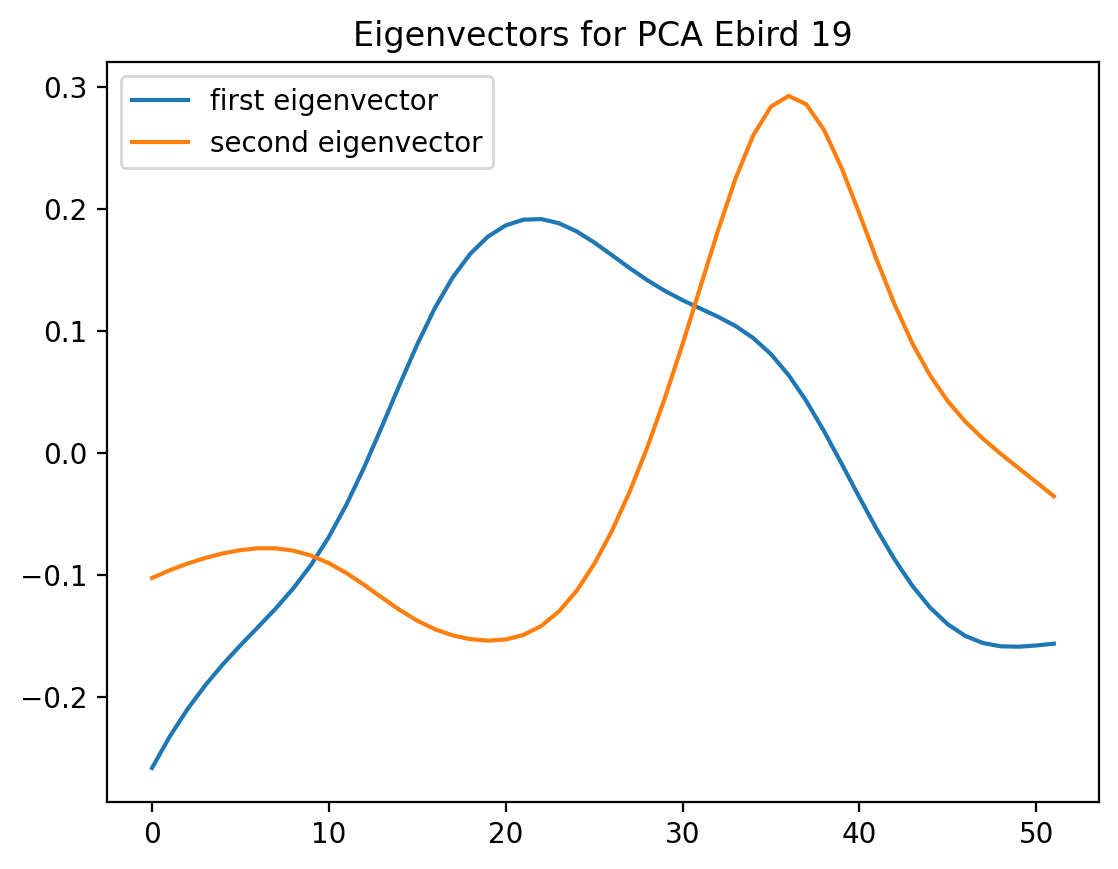

In [192]:
plt.title("Eigenvectors for PCA Ebird 19")
plt.plot(-1*pca_eb_19.components_[0], label='first eigenvector')
plt.plot(pca_eb_19.components_[1], label='second eigenvector')
# plt.plot(pca_eb_19.components_[2], label='third eigenvector')
# plt.plot(pca_eb_19.components_[3], label='fourth eigenvector')
plt.legend()

In [108]:
fpca_discretized = FPCA(n_components=6)
fpca_discretized.fit(llr_fd_dcurv_eb_19)


FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.25      ,
       1.        , 0.41666667]),
     n_components=6)

In [110]:
scree_fpca_discrete = np.cumsum(fpca_discretized.explained_variance_ratio_)

In [111]:
scree_fpca_discrete

array([0.55795179, 0.83098811, 0.89244004, 0.94785193, 0.97460669,
       0.98594934])

In [119]:
fpca_disc_comp = fpca_discretized.components_.data_matrix.reshape(6,52)

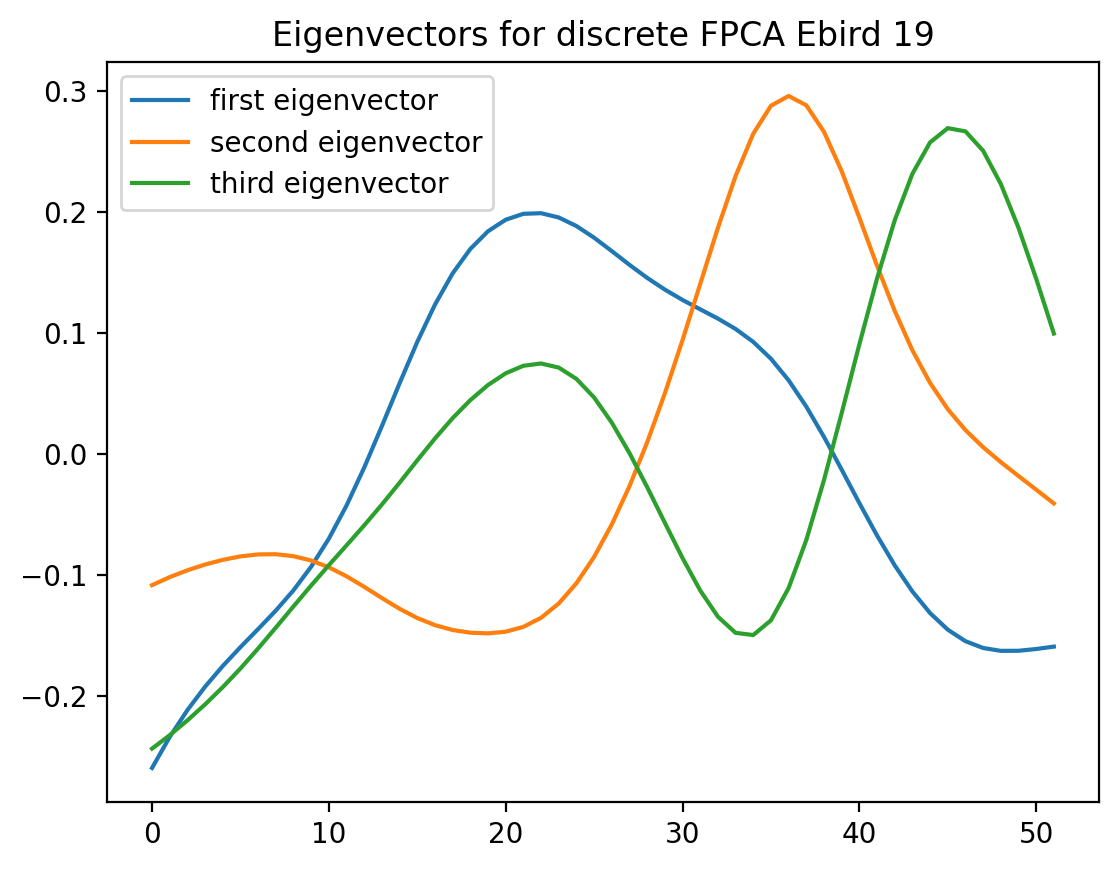

In [124]:
plt.title("Eigenvectors for discrete FPCA Ebird 19")
plt.plot(-1*fpca_disc_comp[0], label='first eigenvector')
plt.plot(fpca_disc_comp[1], label='second eigenvector')
plt.plot(fpca_disc_comp[2], label='third eigenvector')
# plt.plot(fpca_disc_comp[3], label='fourth eigenvector')
plt.legend()

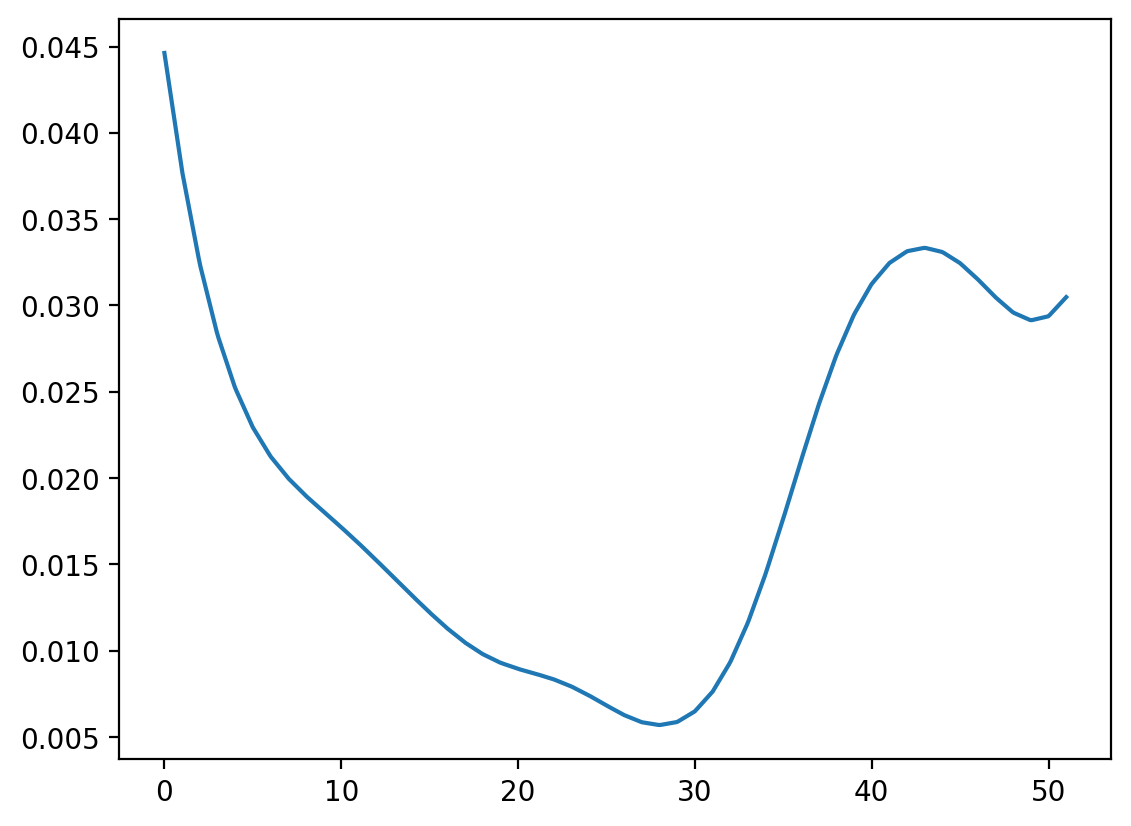

In [130]:
llr_fd_dcurv_eb_19[10].plot()
plt.show()

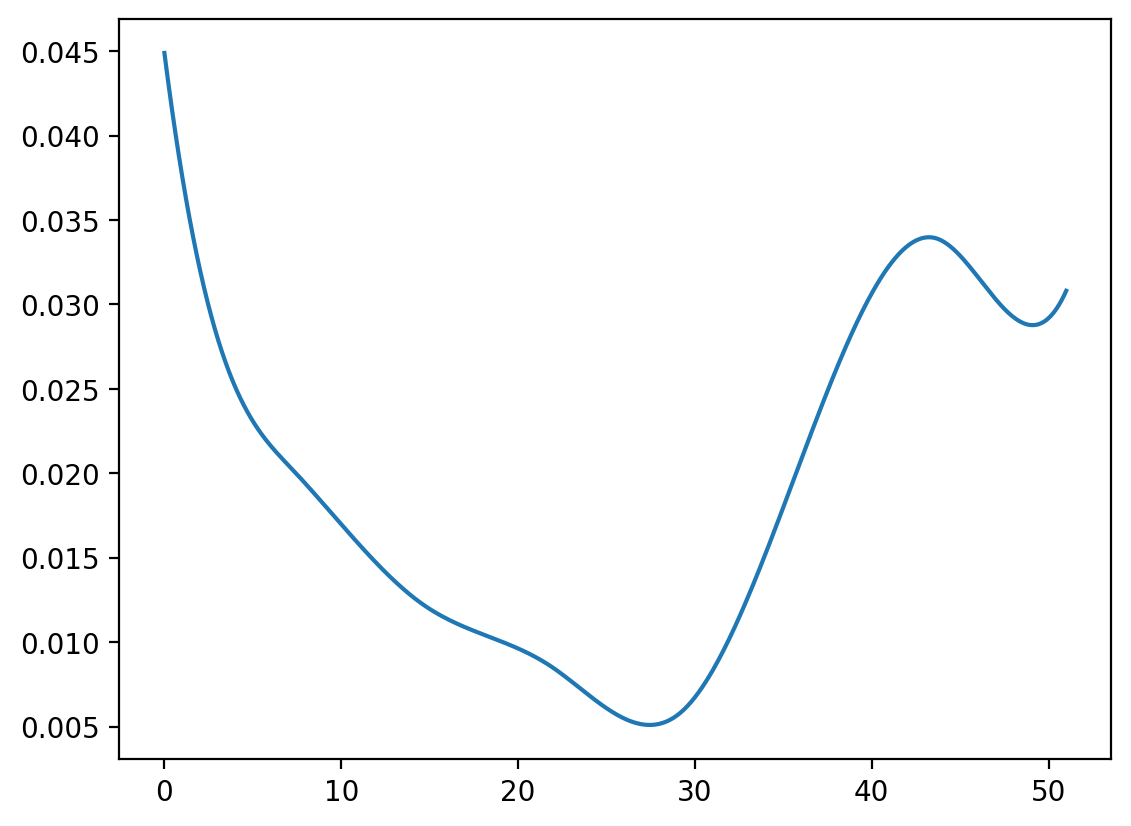

In [128]:
basis = skfda.representation.basis.BSplineBasis(n_basis=10)
basis_fd_spline = llr_fd_dcurv_eb_19.to_basis(basis)
basis_fd_spline[10].plot()
plt.show()

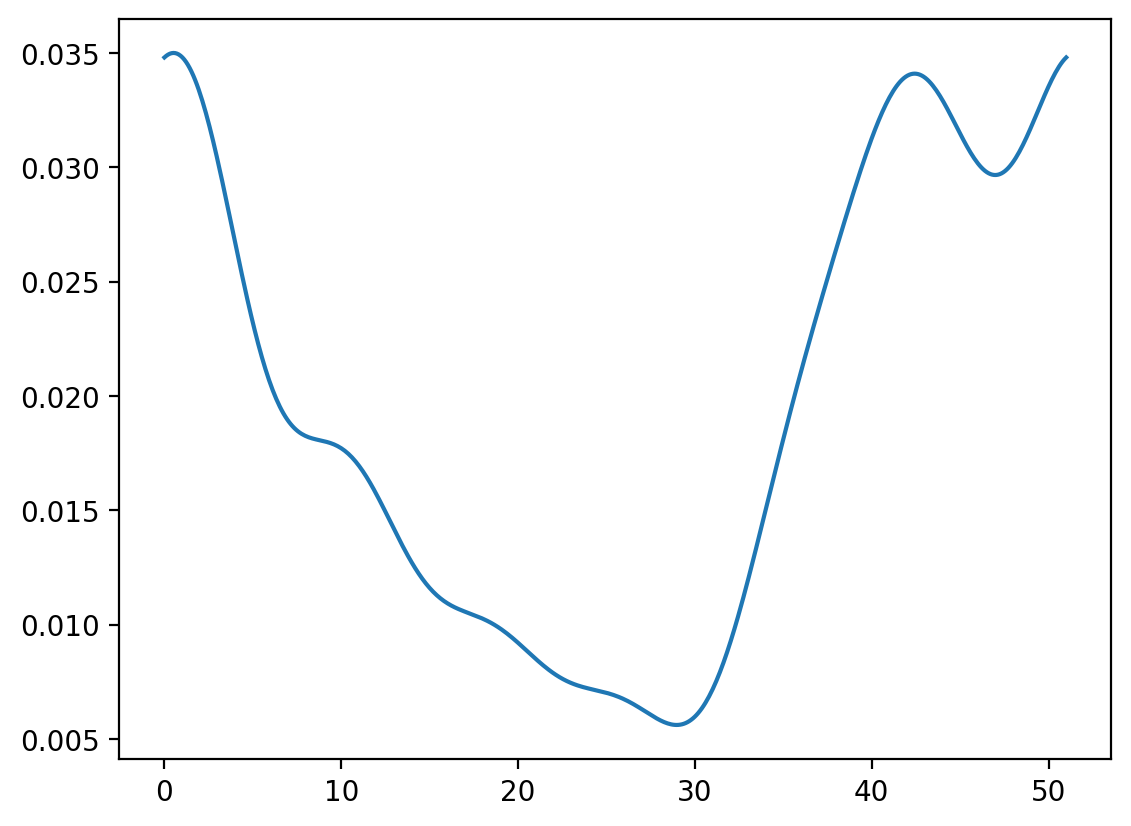

In [134]:
basis = skfda.representation.basis.FourierBasis(n_basis=12)
basis_fd_fourier = llr_fd_dcurv_eb_19.to_basis(basis)
basis_fd_fourier[10].plot()
plt.show()

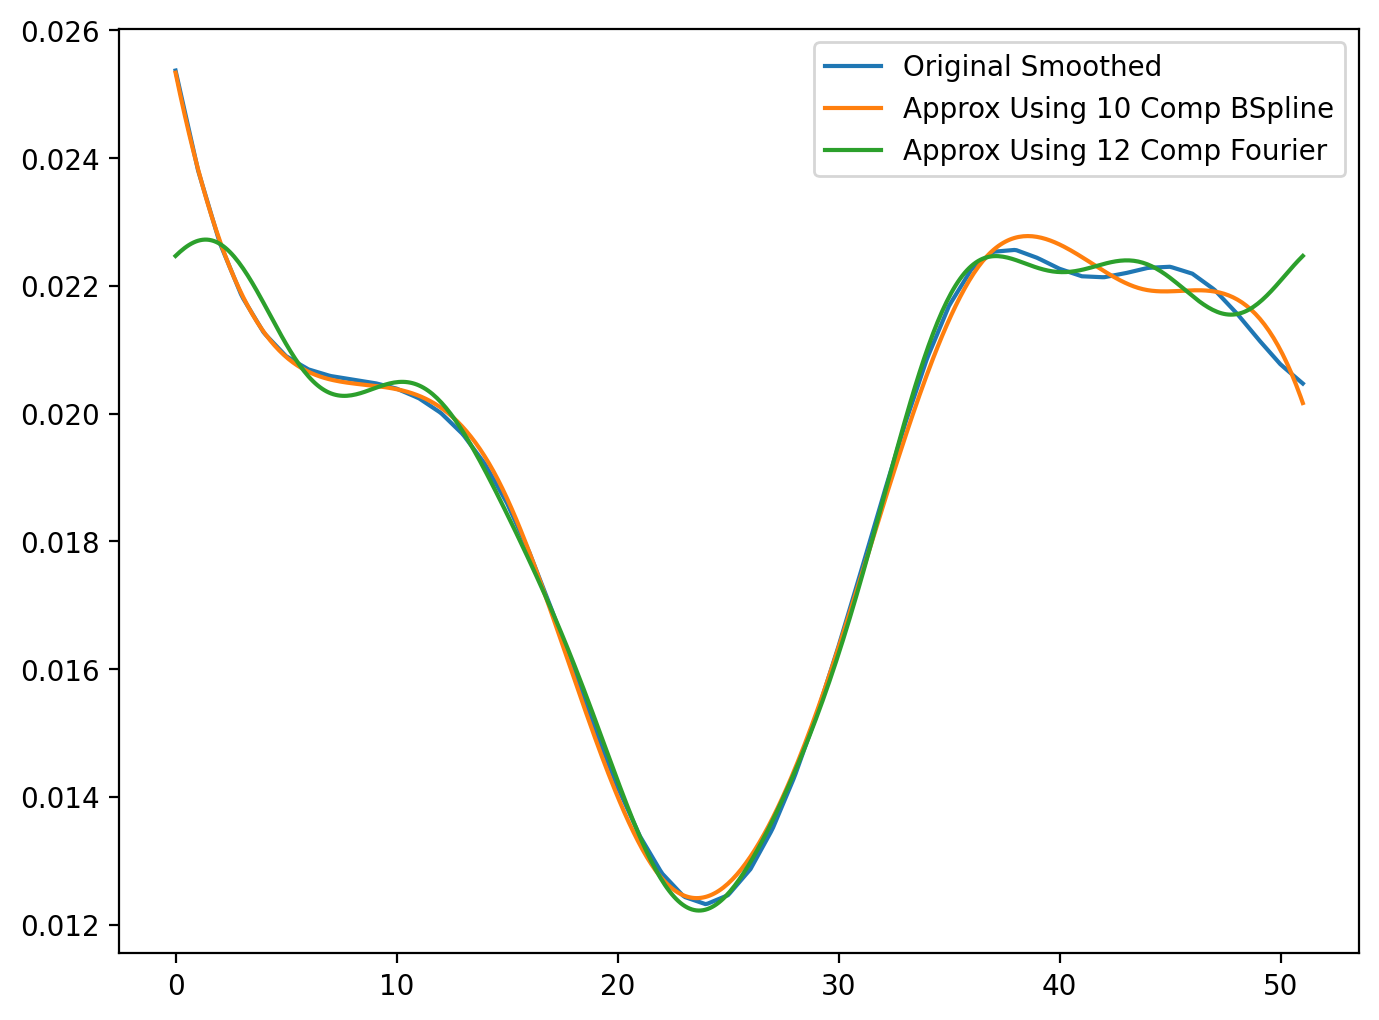

In [195]:
ind = 11
fig, ax = plt.subplots(figsize=(8,6))
llr_fd_dcurv_eb_19[ind].plot(fig=fig, label='Original Smoothed')
basis_fd_spline[ind].plot(fig=fig, label='Approx Using 10 Comp BSpline')
basis_fd_fourier[ind].plot(fig=fig, label='Approx Using 12 Comp Fourier')
plt.legend()
plt.show()

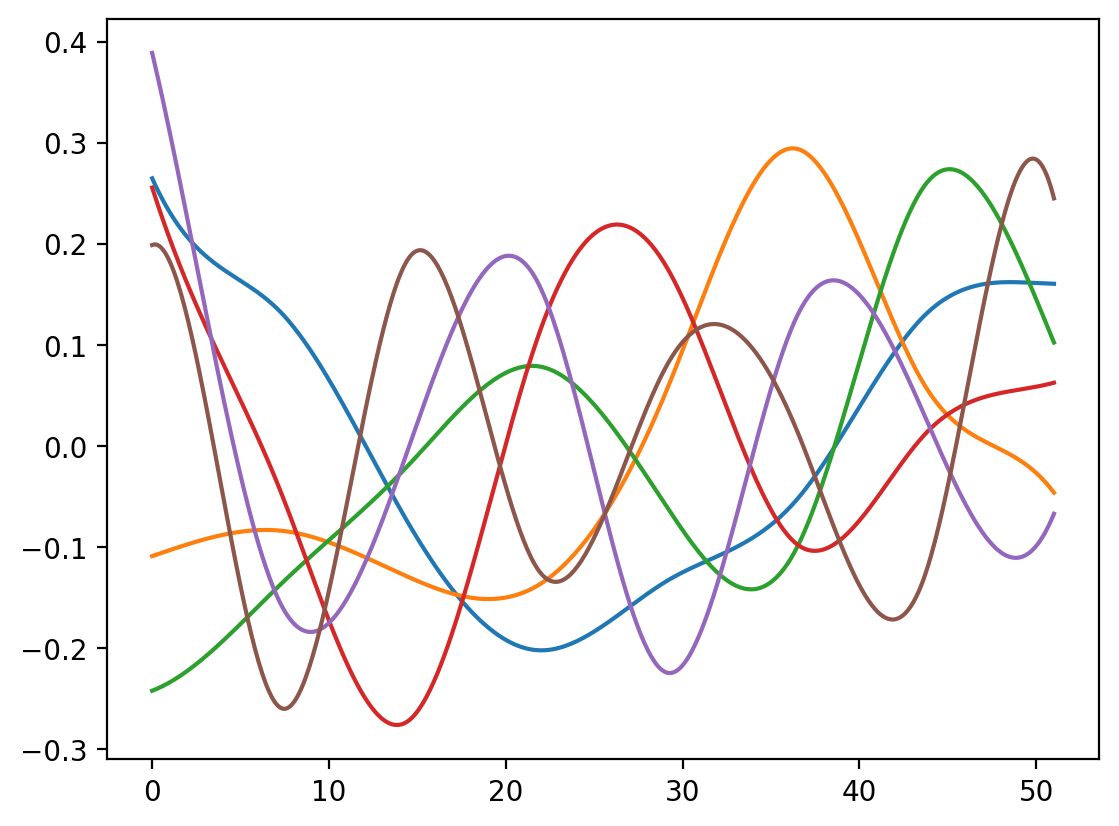

In [140]:
fpca_bspline = FPCA(n_components=6)
fpca_bspline.fit(basis_fd_spline)
fpca_bspline.components_.plot()
plt.show()

In [141]:
np.cumsum(fpca_bspline.explained_variance_ratio_)

array([0.56048015, 0.83531854, 0.89717261, 0.95284645, 0.97963124,
       0.98997643])

In [196]:
basis = skfda.representation.basis.BSplineBasis(n_basis=10)
basis_fd_spline = llr_fd_dcurv_eb_19.to_basis(basis)

In [208]:
basis = skfda.representation.basis.FourierBasis(n_basis=6)

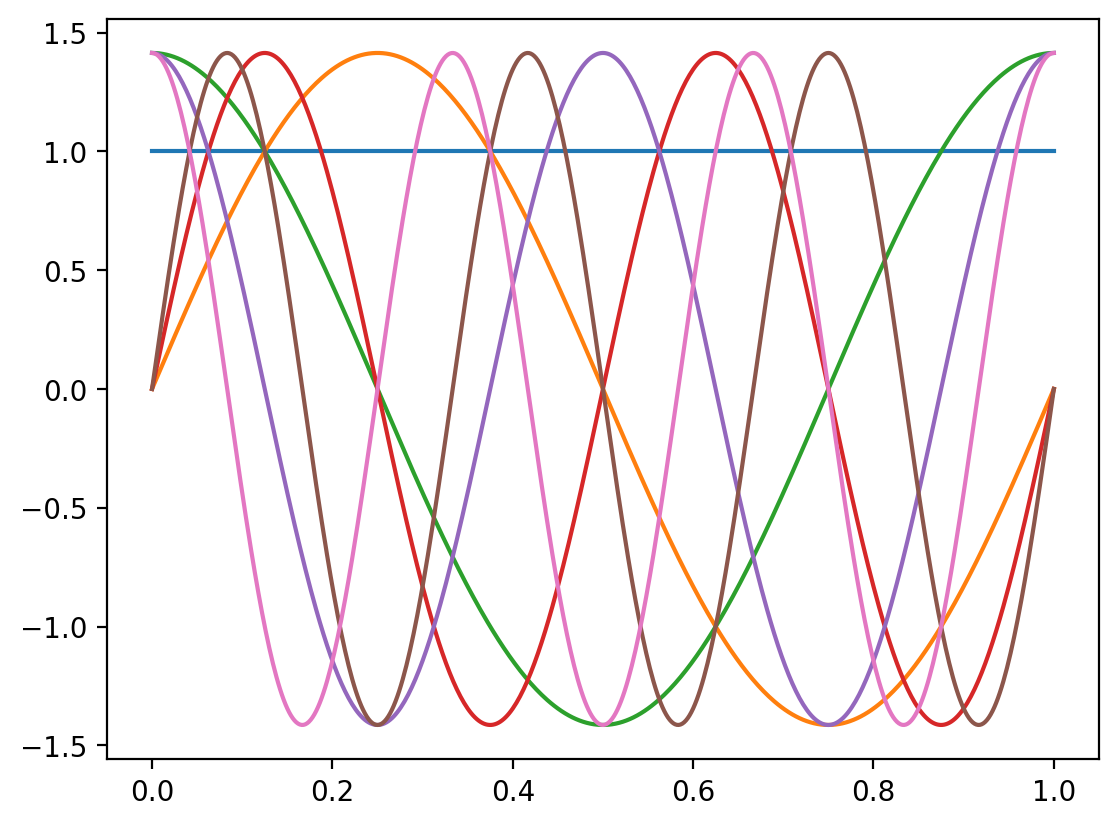

In [209]:
basis.plot()

In [157]:
df_dcurv_eb_19.reset_index(inplace=True)

In [165]:
df_dcurv_eb_19_2 = df_dcurv_eb_19.merge(df_bird_features, on='AVIBASEID', how='left')

In [167]:
df_dcurv_eb_19_2 = df_dcurv_eb_19_2.set_index('AVIBASEID').loc[common_birds, :].copy()

In [174]:
X = df_dcurv_eb_19_2.iloc[:, 56:70]

In [175]:
from sklearn.preprocessing import OneHotEncoder

import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

In [178]:
basis_fd_spline

FDataBasis(
    basis=BSplineBasis(domain_range=((0.0, 51.0),), n_basis=10, order=4, knots=(0.0, 7.285714285714286, 14.571428571428571, 21.857142857142858, 29.142857142857142, 36.42857142857143, 43.714285714285715, 51.0)),
    coefficients=[[0.02276677 0.01859168 0.01370149 ... 0.01686566 0.01685777 0.02069242]
     [0.03287531 0.02543274 0.02013566 ... 0.02129636 0.02108526 0.02157629]
     [0.01271327 0.00428857 0.01387505 ... 0.00918154 0.00709622 0.0064249 ]
     ...
     [0.04346916 0.03787933 0.02220168 ... 0.01390895 0.02733416 0.02283514]
     [0.01924033 0.01666589 0.00734837 ... 0.02028578 0.0172048  0.01386673]
     [0.05634858 0.04864533 0.04283322 ... 0.01933993 0.02359312 0.02548805]],
    dataset_name=None,
    argument_names=(None,),
    coordinate_names=(None,),
    extrapolation=None)

In [186]:
y_fd = llr_fd_dcurv_eb_19[0:200].coordinates[0].to_basis(basis)

In [187]:
funct_reg = LinearRegression(fit_intercept=True)
funct_reg.fit(X.iloc[0:200, :], y_fd)

/Users/devendragovil/AllClassesMaterial/RA_Func/explorations_func_data/.scikit-fda-explore/lib/python3.11/site-packages/skfda/ml/regression/_linear_regression.py:361: UserWarning: All the covariates are scalar.
  warnings.warn("All the covariates are scalar.")


ValueError: Some of the response variables are not scalar